In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules.transformer as transformer
import numpy as np
from tqdm import tqdm
import random

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
# else if mps is available
elif torch.backends.mps.is_available():
    device = "mps"

In [70]:
import torch
import random
from tqdm import tqdm


# Helper function to process each line
def process_line(line):
    x, y = line.strip().split()
    x = torch.tensor([["s", "a", "b", "e", "p"].index(c) for c in x])
    y = torch.tensor(int(y))
    return x, y


# Load data function
def load_data(file_path):
    data = []
    with open(file_path, "r") as f:
        for line in tqdm(f):
            data.append(process_line(line))
    random.shuffle(data)
    return data


# Load and shuffle training and test data
train_data = load_data("ab_data/train_dataset.txt")
test_data = load_data("ab_data/test_dataset.txt")


# Create tensors for all training and test data
def create_tensors(data):
    x = [item[0] for item in data]
    y = [item[1] for item in data]
    return torch.stack(x), torch.tensor(y)


train_x, train_y = create_tensors(train_data)
test_x, test_y = create_tensors(test_data)

312786it [00:17, 17550.74it/s]
78198it [00:04, 18545.40it/s]


In [71]:
seq_len = train_x.size(1)


# Define a custom TransformerEncoderLayer
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2, dropout=0.1):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

    def forward(self, src, key_padding_mask=None, attn_mask=None):
        src = self.layernorm1(
            src
            + self.self_attn(
                src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask
            )[0]
        )
        src = self.layernorm2(
            src + self.linear2(self.dropout(F.relu(self.linear1(src))))
        )
        return src


# Define the model
class TransformerClassifier(nn.Module):
    def __init__(self):
        super(TransformerClassifier, self).__init__()
        self.encoder = CustomTransformerEncoderLayer(d_model=4 + seq_len, nhead=1)
        self.fc = nn.Linear(4 + seq_len, 4)
        self.relu = nn.ReLU()
        self.final_fc = nn.Linear(seq_len * 4, 1, bias=False)
        self.final_bias = nn.Parameter(torch.zeros(1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x is a stack of sequences of indices of length seq_len
        # (N, seq_len)
        # For embeddings, replace each index with a one hot vector that has 1 in that index
        x = F.one_hot(x, num_classes=5).to(device)
        # Replace any [0, 0, 0, 0, 1] with [0, 0, 0, 0, 0]
        embeddings = x[:, :, :-1]  # (N, seq_len, 4)

        # For positional encodings, use a onehot-based positional encoding
        # This is a simple positional encoding that uses one-hot vectors for each position
        pos_enc = torch.eye(seq_len).to(device)  # (seq_len, seq_len)
        # If token is padding, set the positional encoding to 0
        pos_enc = pos_enc.unsqueeze(0).repeat(x.size(0), 1, 1)  # (N, seq_len, seq_len)
        key_padding_mask = torch.all(embeddings == 0, dim=-1)  # (N, seq_len)
        pos_enc = pos_enc.masked_fill(key_padding_mask.unsqueeze(-1), 0)

        # Concatenate the (N, seq_len, embed_dim) and (1, seq_len, seq_len) tensors on the last dimension
        x = torch.cat((embeddings, pos_enc), dim=-1)
        # Want to not attend to any padding tokens
        attention_mask = key_padding_mask.unsqueeze(1)
        # Stack attention_mask seq_len times to match the shape of x
        attention_mask = attention_mask.repeat(1, seq_len, 1)

        x = self.encoder(
            x.transpose(0, 1),
            key_padding_mask=key_padding_mask,
            attn_mask=attention_mask,
        )  # (seq_len, N, embed_dim+seq_len)
        x = x.transpose(0, 1)  # (N, seq_len, embed_dim+seq_len)
        x = self.fc(x)  # (N, seq_len, embed_dim)
        x = self.relu(x)
        # Now we have seq_len embeddings of size embed_dim, run a fc layer to get the final output
        # First zero out all embeddings that are padding
        x = x.masked_fill(key_padding_mask.unsqueeze(-1), 0)
        x = x.view(x.size(0), -1)  # Flatten the embeddings
        x = self.final_fc(x)
        # Scale by the number of non-padding tokens
        x = x / (seq_len - key_padding_mask.sum(dim=-1).unsqueeze(-1)) + self.final_bias
        x = self.sigmoid(x)
        return x

    def print_attention(self, x):
        x = F.one_hot(x, num_classes=5).to(device)
        embeddings = x[:, :, :-1]
        pos_enc = torch.eye(seq_len).to(device)
        pos_enc = pos_enc.unsqueeze(0).repeat(x.size(0), 1, 1)
        key_padding_mask = torch.all(embeddings == 0, dim=-1)
        pos_enc = pos_enc.masked_fill(key_padding_mask.unsqueeze(-1), 0)
        x = torch.cat((embeddings, pos_enc), dim=-1)
        attention_mask = key_padding_mask.unsqueeze(1)
        attention_mask = attention_mask.repeat(1, seq_len, 1)
        x = self.encoder.self_attn(
            x.transpose(0, 1),
            x.transpose(0, 1),
            x.transpose(0, 1),
            key_padding_mask=key_padding_mask,
            attn_mask=attention_mask,
        )[1]
        return x

    def print_pos_enc_attention(self, x):
        x = F.one_hot(x, num_classes=5).to(device)
        x = torch.zeros_like(x)
        embeddings = x[:, :, :-1]
        pos_enc = torch.eye(seq_len).to(device)
        pos_enc = pos_enc.unsqueeze(0).repeat(x.size(0), 1, 1)
        x = torch.cat((embeddings, pos_enc), dim=-1)
        x = self.encoder.self_attn(
            x.transpose(0, 1),
            x.transpose(0, 1),
            x.transpose(0, 1),
            key_padding_mask=None,
            attn_mask=None,
        )[1]
        return x


# Train the model
model = TransformerClassifier()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [77]:
from tqdm import tqdm
from torch import mps
import gc

gc.collect()
mps.empty_cache()
model = model.to(device)
train_x, train_y, test_x, test_y = (
    train_x.to(device),
    train_y.to(device),
    test_x.to(device),
    test_y.to(device),
)


# Train the model
for epoch in range(200):
    # Choose a subset of size 1000
    indices = torch.randperm(len(train_x))[:1000]
    train_x_subset = train_x[indices]
    train_y_subset = train_y[indices]

    model.train()
    optimizer.zero_grad()
    output = model(train_x_subset)
    loss = criterion(output, train_y_subset.float().view(-1, 1))
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    # If epoch is a multiple of 10, evaluate the model on the test data
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            # Pick random 100 samples from the test data
            indices = torch.randperm(len(test_x))[:200]
            test_x_subset = test_x[indices]
            test_y_subset = test_y[indices]
            output = model(test_x_subset)
            # Calculate the accuracy
            correct = (output > 0.5).squeeze(1).float() == test_y_subset.float()
            accuracy = correct.sum() / len(correct)
            print(f"Accuracy: {accuracy.item()}")

Epoch 1, Loss: 0.6933107972145081
Epoch 2, Loss: 0.6931241154670715
Epoch 3, Loss: 0.6930974721908569
Epoch 4, Loss: 0.6931241154670715
Epoch 5, Loss: 0.6930387020111084
Epoch 6, Loss: 0.6931454539299011
Epoch 7, Loss: 0.6931453943252563
Epoch 8, Loss: 0.6931294798851013
Epoch 9, Loss: 0.6931561827659607
Epoch 10, Loss: 0.6932414770126343
Accuracy: 0.5
Epoch 11, Loss: 0.6933268308639526
Epoch 12, Loss: 0.6932308673858643
Epoch 13, Loss: 0.6931028366088867
Epoch 14, Loss: 0.6930867433547974
Epoch 15, Loss: 0.6931453943252563
Epoch 16, Loss: 0.6930654644966125
Epoch 17, Loss: 0.6931453943252563
Epoch 18, Loss: 0.6931774616241455
Epoch 19, Loss: 0.6930761337280273
Epoch 20, Loss: 0.6930974721908569
Accuracy: 0.4449999928474426
Epoch 21, Loss: 0.6932574510574341
Epoch 22, Loss: 0.6931453943252563
Epoch 23, Loss: 0.6931400895118713
Epoch 24, Loss: 0.6932361125946045
Epoch 25, Loss: 0.6931827664375305
Epoch 26, Loss: 0.6932361721992493
Epoch 27, Loss: 0.692990779876709
Epoch 28, Loss: 0.6931

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x33334eac0>
    label = <none> 
    device = <AGXG14CDevice: 0x12fdad800>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x2dc00b800>
        label = <none> 
        device = <AGXG14CDevice: 0x12fdad800>
            name = Apple M2 Max 
    retainedReferences = 1


Epoch 48, Loss: 0.6930867433547974
Epoch 49, Loss: 0.6931614875793457
Epoch 50, Loss: 0.6932948231697083
Accuracy: 0.4000000059604645
Epoch 51, Loss: 0.6931667923927307
Epoch 52, Loss: 0.6931134462356567


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x31bcd8b30>
    label = <none> 
    device = <AGXG14CDevice: 0x12fdad800>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x2dc00b800>
        label = <none> 
        device = <AGXG14CDevice: 0x12fdad800>
            name = Apple M2 Max 
    retainedReferences = 1


Epoch 53, Loss: 0.6931988000869751
Epoch 54, Loss: 0.6932095289230347
Epoch 55, Loss: 0.6930760741233826
Epoch 56, Loss: 0.6931774616241455
Epoch 57, Loss: 0.6931508183479309
Epoch 58, Loss: 0.6930601000785828
Epoch 59, Loss: 0.6931241154670715
Epoch 60, Loss: 0.6930334568023682
Accuracy: 0.5350000262260437
Epoch 61, Loss: 0.6930280923843384
Epoch 62, Loss: 0.6930387020111084
Epoch 63, Loss: 0.6932095289230347
Epoch 64, Loss: 0.6931881308555603
Epoch 65, Loss: 0.6931667923927307
Epoch 66, Loss: 0.6931721568107605


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3333cf250>
    label = <none> 
    device = <AGXG14CDevice: 0x12fdad800>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x2dc00b800>
        label = <none> 
        device = <AGXG14CDevice: 0x12fdad800>
            name = Apple M2 Max 
    retainedReferences = 1


Epoch 67, Loss: 0.6930867433547974
Epoch 68, Loss: 0.6932148337364197
Epoch 69, Loss: 0.6932788491249084
Epoch 70, Loss: 0.6931188106536865
Accuracy: 0.5149999856948853
Epoch 71, Loss: 0.6933001279830933
Epoch 72, Loss: 0.6930707693099976
Epoch 73, Loss: 0.6933162212371826
Epoch 74, Loss: 0.6931134462356567
Epoch 75, Loss: 0.6931721568107605
Epoch 76, Loss: 0.6933162212371826
Epoch 77, Loss: 0.6930121183395386
Epoch 78, Loss: 0.6931881308555603
Epoch 79, Loss: 0.6931241750717163
Epoch 80, Loss: 0.6931828260421753
Accuracy: 0.5
Epoch 81, Loss: 0.6930920481681824
Epoch 82, Loss: 0.6931134462356567
Epoch 83, Loss: 0.6930813193321228
Epoch 84, Loss: 0.6930974721908569
Epoch 85, Loss: 0.6931667923927307
Epoch 86, Loss: 0.6933268308639526
Epoch 87, Loss: 0.6931508183479309
Epoch 88, Loss: 0.6933107972145081
Epoch 89, Loss: 0.6931508183479309
Epoch 90, Loss: 0.6931827664375305
Accuracy: 0.5049999952316284
Epoch 91, Loss: 0.6931241154670715
Epoch 92, Loss: 0.6932148933410645
Epoch 93, Loss: 0.

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x2a153b6a0>
    label = <none> 
    device = <AGXG14CDevice: 0x12fdad800>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x2dc00b800>
        label = <none> 
        device = <AGXG14CDevice: 0x12fdad800>
            name = Apple M2 Max 
    retainedReferences = 1


Epoch 139, Loss: 0.6932788491249084
Epoch 140, Loss: 0.6931987404823303
Accuracy: 0.5049999952316284
Epoch 141, Loss: 0.6930112838745117
Epoch 142, Loss: 0.6931667923927307
Epoch 143, Loss: 0.6931667923927307
Epoch 144, Loss: 0.6931667923927307
Epoch 145, Loss: 0.6930707693099976
Epoch 146, Loss: 0.6933162212371826
Epoch 147, Loss: 0.6931401491165161
Epoch 148, Loss: 0.6931561827659607
Epoch 149, Loss: 0.6931988000869751
Epoch 150, Loss: 0.6931881308555603
Accuracy: 0.4699999988079071
Epoch 151, Loss: 0.6931454539299011
Epoch 152, Loss: 0.6931615471839905
Epoch 153, Loss: 0.6931134462356567
Epoch 154, Loss: 0.6931188106536865
Epoch 155, Loss: 0.6930654048919678
Epoch 156, Loss: 0.6929801106452942
Epoch 157, Loss: 0.6930974125862122
Epoch 158, Loss: 0.6930814385414124
Epoch 159, Loss: 0.6930120587348938
Epoch 160, Loss: 0.6931667923927307
Accuracy: 0.5450000166893005
Epoch 161, Loss: 0.6931028366088867
Epoch 162, Loss: 0.6932148337364197
Epoch 163, Loss: 0.6931774020195007
Epoch 164, Lo

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x2e218fc80>
    label = <none> 
    device = <AGXG14CDevice: 0x12fdad800>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x2dc00b800>
        label = <none> 
        device = <AGXG14CDevice: 0x12fdad800>
            name = Apple M2 Max 
    retainedReferences = 1


Epoch 190, Loss: 0.6932255029678345
Accuracy: 0.4950000047683716
Epoch 191, Loss: 0.6930707693099976
Epoch 192, Loss: 0.6930601000785828
Epoch 193, Loss: 0.6930174231529236
Epoch 194, Loss: 0.6929747462272644
Epoch 195, Loss: 0.6931028366088867
Epoch 196, Loss: 0.6930921077728271
Epoch 197, Loss: 0.6930173635482788
Epoch 198, Loss: 0.6931508779525757
Epoch 199, Loss: 0.6931988000869751
Epoch 200, Loss: 0.6932361125946045
Accuracy: 0.550000011920929


In [78]:
model.eval()
with torch.no_grad():
    correct = 0
    batch_size = 100
    for i in tqdm(range(0, len(test_x), batch_size)):
        batch_end = min(i + batch_size, len(test_x))
        output = model(test_x[i:batch_end].to("mps"))
        y = test_y[i:batch_end].to("mps")
        predictions = (output > 0.5).squeeze().float()

        # Ensure predictions and y have the same shape
        if predictions.shape != y.shape:
            predictions = predictions.view_as(y)

        correct += (predictions == y.float()).sum().item()
    accuracy = correct / len(test_x)

print(f"Test accuracy: {accuracy}")

100%|██████████| 782/782 [00:12<00:00, 60.58it/s]

Test accuracy: 0.5


In [74]:
# Save the model
torch.save(model.state_dict(), "updated_ab_model.pth")

tensor([[0.4987]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([118, 121, 120, 116, 106, 112, 119, 110, 117, 114], device='mps:0')
pppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppsaaaaaaaaaaaaaaaababbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbepppppppppppppppppppppppppppppppppppppppppppppppppp


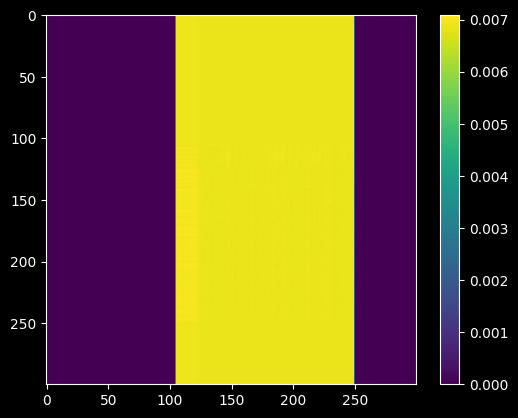

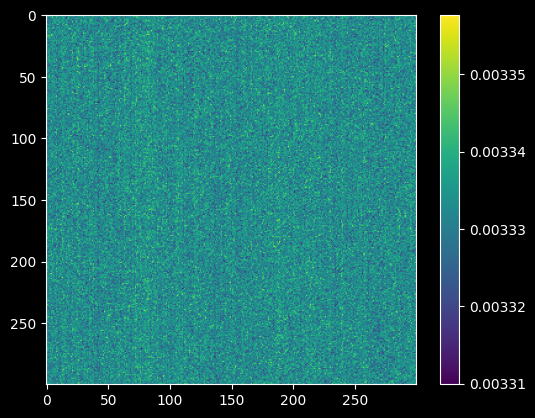

In [75]:
# Load model, pick random sample from training set and print attention weights
mps.empty_cache()
model = TransformerClassifier()
model.load_state_dict(
    torch.load("updated_ab_model.pth", map_location=torch.device("mps"))
)
model.to("mps")
model.eval()
index = random.randint(0, len(train_x) - 1)
x = train_x[index].unsqueeze(0).to("mps")
output = model(x)
print(output)
attn_weights = model.print_attention(x)
# Print indices of top 10 attention weights
print(torch.topk(attn_weights.squeeze(0).mean(dim=0), 10).indices)

# Print the original string
print("".join(["s", "a", "b", "e", "p"][i] for i in train_x[index].tolist()))

# Plot matrix of attention weights
import matplotlib.pyplot as plt

plt.imshow(attn_weights.cpu().squeeze(0).detach().numpy())
plt.colorbar()
plt.show()

# Print positional encoding attention weights
attn_weights = model.print_pos_enc_attention(x)
plt.imshow(attn_weights.cpu().squeeze(0).detach().numpy())
plt.colorbar()
plt.show()

In [76]:
# Do PCA on the position embeddings so they have 2 dimensions isntead of 4
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(model.position_embedding.weight.data.numpy())
position_embedding_pca = pca.transform(model.position_embedding.weight.data.numpy())
# In scatterplot plot just the first 100 position embeddings with line from 0 to 1, 1 to 2, 2 to 3, 3 to 4, etc
n = 20
plt.scatter(position_embedding_pca[:n, 0], position_embedding_pca[:n, 1])
for i in range(n):
    plt.plot(
        position_embedding_pca[i : i + 2, 0], position_embedding_pca[i : i + 2, 1], "r-"
    )
plt.show()

AttributeError: 'TransformerClassifier' object has no attribute 'position_embedding'